In [137]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from sklearn.cluster import KMeans

In [2]:
slope = 5.7115e13 # 6.0012 * 1e13
number_of_samples_per_second = 4.4 * 1e6
# chirp_frequency = 1/0.0001/2
chirp_frequency = 4710

file_path = "vitals_data_03;08/3-08-14;50/"

N = 256
speed_of_light = 2.99792458 * 1e8
r = 3.2e-3

target_num = 2
target_distance_in_meter = 0.25
distance_max_range_in_meter = 1.5

wave_length = speed_of_light/(77*1e9)

resolution = speed_of_light*number_of_samples_per_second/2/slope/N
print(resolution, resolution*N)

0.04510796526197146 11.547639107064693


In [28]:
class raw_data():
    def __init__(self, raw_real_file_name, raw_imag_file_name, slope=6.0012 * 1e13, number_of_samples_per_second=4.4 * 1e6, target_num=1, target_distance_in_meter=0.25, distance_max_range_in_meter=1.5):

        # self.slope = 2.9982 * 1e13
        # self.number_of_samples_per_second = 10 * 1e6
        self.slope = slope
        self.number_of_samples_per_second = number_of_samples_per_second
        self.speed_of_light = 2.99792458 * 1e8
        self.complex_data = self.read_complex_data(raw_real_file_name, raw_imag_file_name)

        idx2dist = lambda idxs: np.array([idx*(number_of_samples_per_second/N * speed_of_light) / (2 * slope) for idx in idxs])
        dist2idx = lambda dist: np.round(dist*(2*slope)/(number_of_samples_per_second/N * speed_of_light)).astype(int)
        self.target_distance = dist2idx(target_distance_in_meter)
        self.distance_max_range = dist2idx(distance_max_range_in_meter)
        self.target_num = target_num

        self.all_distances = []
        self.x_fft = []
        self.peak_distances = []
        self.peak_idx = []
        self.find_distance(self.complex_data)

    
    def read_complex_data(self, raw_real_file_name, raw_imag_file_name):
        '''
        read real and imag data from file and return the complex data
        return: complex_data (N x bin_size)
        '''
        real_data = []
        imag_data = []
        complex_data = []
        with open(raw_real_file_name, "r") as f:
            real_data = [batch.split(",")[:-1] for batch in f.readlines()]
        with open(raw_imag_file_name, "r") as f:
            imag_data = [batch.split(",")[:-1] for batch in f.readlines()]

        if len(real_data) != len(imag_data):
            raise("real and imag data does not have same len")

        complex_data = np.array(real_data, dtype=int) + np.array(imag_data, dtype=complex)
        if np.shape(complex_data)[0] == 1:
            complex_data = np.reshape(complex_data, (np.shape(complex_data)[1]//N, N))
        return complex_data

    def find_distance(self, all_complex_data):
        x_fft = []
        peak_distances = []
        peak_idx = []


        number_of_samples = len(all_complex_data[0])
        fundamental_frequency = self.number_of_samples_per_second/number_of_samples
        frequencies = np.linspace(0, number_of_samples, number_of_samples)*fundamental_frequency
        self.all_distances = frequencies * self.speed_of_light / (2 * self.slope)

        for data in all_complex_data:
            iq_frequency = np.fft.fft(data)

            magnitude = np.abs(iq_frequency)
            # max_idx = np.argmax(magnitude)
            peaks, _ = signal.find_peaks(magnitude[:self.distance_max_range], distance=self.target_distance)
            target_idxs = np.argsort(magnitude[:self.distance_max_range][peaks])[-self.target_num:]
            frequency_peak = frequencies[peaks[target_idxs]]
            distance = (frequency_peak * self.speed_of_light) / (2 * self.slope)

            x_fft.append(iq_frequency)
            peak_distances.append(distance)
            peak_idx.append(peaks[target_idxs])

        self.x_fft = np.array(x_fft)
        self.peak_distances = np.array(peak_distances)
        self.peak_idx = np.array(peak_idx)
        # return np.array(x_fft), np.array(peak_distances)

    def plot_spectrogram(self):
        t = np.arange(len(self.x_fft))
        f = np.linspace(0, self.number_of_samples_per_second, len(self.x_fft[0]))[:self.distance_max_range] * (self.speed_of_light/2/self.slope)
        plt.pcolormesh(t, f, np.abs(self.x_fft.T)[:self.distance_max_range])
        plt.ylabel("Distance (m)")
    


In [155]:
class AoA():
    def __init__(self, chans, r=3.2e-3, wave_length=2.99792458e8/77e9, target_num=1):

        self.num_chan = len(chans)
        self.r = r
        self.wave_length = wave_length
        self.target_num = target_num
        self.phase_diff = np.angle(chans[0].x_fft/chans[1].x_fft)

        self.matching_phase = []
        self.peak_phase = []
        self.matching_distance = []
        self.matching_magnitude = []
        self.matching_angles = []
        self.angles = []
        self.find_AoA(chans[0], chans[1])

        
    def find_AoA(self, chan1, chan2):
        matching_phase = []
        peak_phase = []
        matching_distance = []
        matching_magnitude = []
        for t_id in range(target_num):
            for i in range(len(chan1.peak_idx)):
                if len(chan1.peak_idx[i]) == 0:
                    continue
                peak_phase.append(self.phase_diff[i][chan1.peak_idx[i][t_id]])
                if chan1.peak_idx[i][t_id] == chan2.peak_idx[i][t_id]:
                    matching_phase.append(self.phase_diff[i][chan1.peak_idx[i][t_id]])
                    matching_distance.append(chan1.peak_distances[i][t_id])
                    matching_magnitude.append(np.abs(chan1.x_fft[i][chan1.peak_idx[i][t_id]]))
        self.matching_phase = np.array(matching_phase)
        self.peak_phase = np.array(peak_phase)
        self.matching_distance = np.array(matching_distance)
        self.matching_magnitude = np.array(matching_magnitude)

        self.matching_angles = np.arccos(self.matching_phase/np.pi*self.wave_length/self.r)
        
        angles = self.matching_angles[~np.isnan(self.matching_angles)]
        kmeans = KMeans(n_clusters=2).fit(angles.reshape(-1,1))
        self.angles = np.rad2deg(kmeans.cluster_centers_)

In [133]:
class Vital_Sign():
    def __init__(self, chan, target_idx, chirp_frequency=4710, cutoff=[0,-1], sub_sample=100, HR_range=[0.9, 1.5], RR_range=[0.2, 0.5], use_numpy_unwrap=True):

        self.phase = []
        self.phase_shift_chart = []
        for target_bin in target_idx:
            phase = [np.angle(chan.complex_data[i][target_bin]) for i, idx in enumerate(chan.peak_idx)][cutoff[0]:cutoff[1]:sub_sample]
            if use_numpy_unwrap:
                phase_shift_chart = np.unwrap(phase)
            else:
                phase_shift_chart = self.unwrap(phase)
            self.phase.append(phase)
            self.phase_shift_chart.append(phase_shift_chart)
        self.freq_reso = chirp_frequency/len(self.phase_shift_chart[0])/2/sub_sample
        
        self.HR = []
        self.RR = []
        for target_bin in range(len(target_idx)):
            self.extract_vital_sign(self.phase_shift_chart[target_bin], HR_range=HR_range, RR_range=RR_range)

    def extract_vital_sign(self, phase_shift_chart, HR_range=[0.9, 1.5], RR_range=[0.2, 0.5]):
        h_s = HR_range[0]
        h_e = HR_range[1]
        s = int(np.round(h_s/self.freq_reso))
        e = int(np.round(h_e/self.freq_reso))
        HR_signal = np.abs(np.fft.fft(phase_shift_chart))[s:e]
        peaks, _ = signal.find_peaks(HR_signal)
        HR_idx = np.argsort(HR_signal[peaks])[-1]
        self.HR.append(np.arange(s,e)[peaks[HR_idx]]*self.freq_reso*60)

        r_s = RR_range[0]
        r_e = RR_range[1]
        s = int(np.round(r_s/self.freq_reso))
        e = int(np.round(r_e/self.freq_reso))
        RR_signal = np.abs(np.fft.fft(phase_shift_chart))[s:e]
        peaks, _ = signal.find_peaks(RR_signal)
        RR_idx = np.argsort(RR_signal[peaks])[-1]
        self.RR.append(np.arange(s,e)[peaks[RR_idx]]*self.freq_reso*60)


    def plot_phase(self, target_idx=0):
        plt.figure(figsize=(30,5))
        plt.plot(self.phase[target_idx])
        plt.title("original phase")
        plt.show()
        plt.figure(figsize=(30,5))
        plt.title("unwrapped")
        plt.plot(self.phase_shift_chart[target_idx])
        plt.show()
    
    def unwrap(self, phase):
        unwrapped = np.unwrap(phase)
        out = [unwrapped[0]]
        flip = 1
        for i in range(1, len(unwrapped)):
            diff = unwrapped[i] - unwrapped[i-1]
            if np.abs(out[-1] + diff*flip) > np.pi:
                if out[-1] + diff*flip > 0:
                    cur = np.pi - (np.abs(out[-1] + diff*flip) - np.pi)
                else:
                    cur = -np.pi + (np.abs(out[-1] + diff*flip) - np.pi)
                out.append(cur)
                flip *= -1
            else:
                cur = out[-1] + diff*flip 
                out.append(cur)
        return out

    def plot_vital_signs(self, phase_shift_chart, HR_range=[0.9, 1.5], RR_range=[0.2, 0.5]):
        h_s = HR_range[0]
        h_e = HR_range[1]
        s = int(np.round(h_s/self.freq_reso))
        e = int(np.round(h_e/self.freq_reso))
        HR_signal = np.abs(np.fft.fft(phase_shift_chart))[s:e]
        peaks, _ = signal.find_peaks(HR_signal)
        HR_idx = np.argsort(HR_signal[peaks])[-1]
        plt.plot(np.arange(s,e)*self.freq_reso*60, HR_signal)
        plt.plot(np.arange(s,e)[peaks]*self.freq_reso*60, HR_signal[peaks], "x")
        plt.plot(np.arange(s,e)[peaks[HR_idx]]*self.freq_reso*60, HR_signal[peaks[HR_idx]], "rx")
        plt.title(f"HR {h_s}-{h_e}Hz, {int(h_s*60)}-{int(h_e*60)}bpm")
        plt.xlabel("Beat")
        plt.ylabel("mag")
        plt.show()

        r_s = RR_range[0]
        r_e = RR_range[1]
        s = int(np.round(r_s/self.freq_reso))
        e = int(np.round(r_e/self.freq_reso))
        RR_signal = np.abs(np.fft.fft(phase_shift_chart))[s:e]
        peaks, _ = signal.find_peaks(RR_signal)
        RR_idx = np.argsort(RR_signal[peaks])[-1]
        plt.plot(np.arange(s,e)*self.freq_reso*60, RR_signal)
        plt.plot(np.arange(s,e)[peaks]*self.freq_reso*60, RR_signal[peaks], "x")
        plt.plot(np.arange(s,e)[peaks[RR_idx]]*self.freq_reso*60, RR_signal[peaks[RR_idx]], "rx")
        plt.title(f"RR {r_s}-{r_e}Hz, {int(r_s*60)}-{int(r_e*60)}bpm")
        plt.xlabel("Beat")
        plt.ylabel("mag")

In [30]:
raw_real_file_name_1 = file_path + "real_converted_data_1.txt"
raw_imag_file_name_1 = file_path + "imag_converted_data_1.txt"
chan = raw_data(raw_real_file_name_1, raw_imag_file_name_1, slope=slope, number_of_samples_per_second=number_of_samples_per_second, target_num=target_num, target_distance_in_meter=target_distance_in_meter, distance_max_range_in_meter=distance_max_range_in_meter)

<ipython-input-28-36bdc96c5271>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.peak_distances = np.array(peak_distances)
<ipython-input-28-36bdc96c5271>:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.peak_idx = np.array(peak_idx)


In [31]:
raw_real_file_name_2 = file_path + "real_converted_data_2.txt"
raw_imag_file_name_2 = file_path + "imag_converted_data_2.txt"
chan2 = raw_data(raw_real_file_name_2, raw_imag_file_name_2, slope=slope, number_of_samples_per_second=number_of_samples_per_second, target_num=target_num, target_distance_in_meter=target_distance_in_meter, distance_max_range_in_meter=distance_max_range_in_meter)

<ipython-input-28-36bdc96c5271>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.peak_distances = np.array(peak_distances)
<ipython-input-28-36bdc96c5271>:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.peak_idx = np.array(peak_idx)


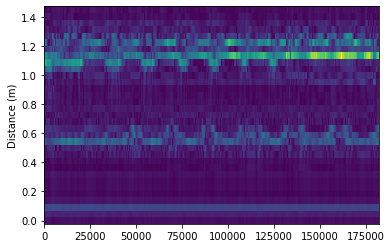

In [41]:
chan.plot_spectrogram()

In [43]:
target_idx = chan.peak_idx[150000]
target_idx

array([12, 25])

In [168]:
target_idx

array([[12, 24]])

In [169]:
target_idx = chan.peak_idx
target_idx = np.array([x for x in target_idx if len(x) != 0])
kmeans = KMeans(n_clusters=1).fit(target_idx)
target_idx = np.around(kmeans.cluster_centers_[0]).astype(int)

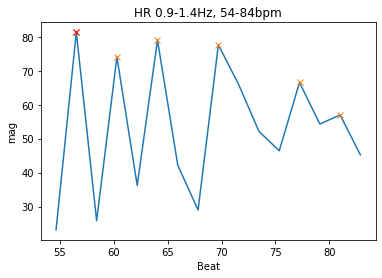

[64.05600000000001, 64.05600000000001]
[15.072000000000003, 15.072000000000003]


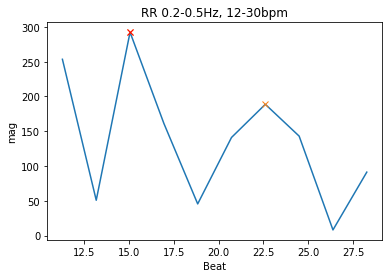

In [178]:
chan_VS = Vital_Sign(chan, target_idx, chirp_frequency=chirp_frequency, cutoff=[0,75000], sub_sample=100, HR_range=[1.0, 1.4], RR_range=[0.2, 0.5], use_numpy_unwrap=True)
chan_VS.plot_vital_signs(chan_VS.phase_shift_chart[0], HR_range=[0.9, 1.4], RR_range=[0.2, 0.5])
print(chan_VS.HR)
print(chan_VS.RR)

In [156]:
aoa = AoA([chan, chan2], r=r, wave_length=wave_length, target_num=2)
aoa.angles

<ipython-input-155-be840c941fcd>:8: RuntimeWarning: invalid value encountered in true_divide
  self.phase_diff = np.angle(chans[0].x_fft/chans[1].x_fft)
<ipython-input-155-be840c941fcd>:38: RuntimeWarning: invalid value encountered in arccos
  self.matching_angles = np.arccos(self.matching_phase/np.pi*self.wave_length/self.r)


array([[ 87.16432247],
       [140.91332994]])

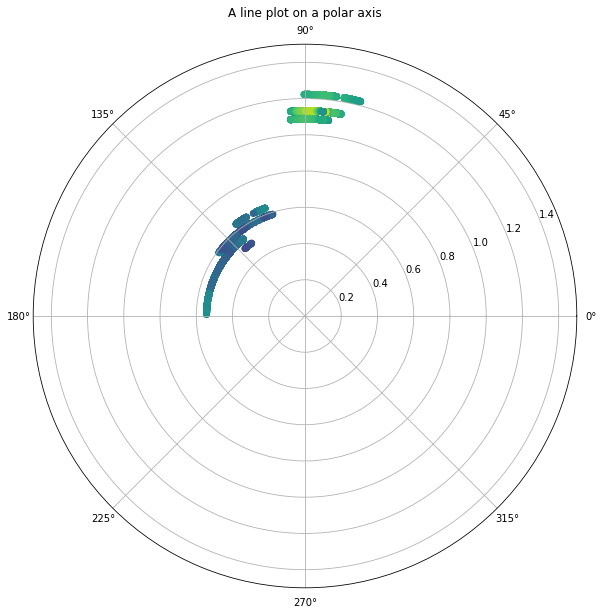

In [34]:
distance = aoa.matching_distance
theta = aoa.matching_angles
z = aoa.matching_magnitude

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10,10))
ax.scatter(theta, distance, c=np.log(z))

ax.set_rmax(1.5)
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()